# STABLE DIFFUSION INPAINTING

In [1]:
import os
import tensorflow as tf
import numpy as np
import transformers
from transformers import create_optimizer, TFSegformerForSemanticSegmentation
import cv2
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

/opt/homebrew/Caskroom/miniforge/base/envs/ComputerVision/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
dataFrame = pd.read_csv('Dataset/labels.csv')
ID2LABEL = {}
for i, j in dataFrame.iterrows():
    if i==0:
        ID2LABEL[i] = 'nan'
    else:
        ID2LABEL[i] = j['label_list']
LABEL2ID = {v: k for k, v in ID2LABEL.items()}
NUM_CLASSES = len(ID2LABEL)

In [3]:
modelID = "nvidia/segformer-b5-finetuned-cityscapes-1024-1024"
model = TFSegformerForSemanticSegmentation.from_pretrained(
    modelID,
    num_labels=NUM_CLASSES,
    id2label=ID2LABEL,
    label2id=LABEL2ID,
    ignore_mismatched_sizes=True)

model.load_weights('Models/Segformer-B5.h5')

2025-02-09 20:15:17.267832: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3 Pro
2025-02-09 20:15:17.267865: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 18.00 GB
2025-02-09 20:15:17.267869: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 6.00 GB
I0000 00:00:1739160917.268382 12189093 pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
I0000 00:00:1739160917.268425 12189093 pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
All model checkpoint layers were used when initializing TFSegformerForSemanticSegmentation.

Some weights of TFSegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/segformer-b5-finetuned-cityscapes-1024-1024 and are newly i

In [4]:
MEAN = [123.675, 116.28, 103.53]
STD = [58.395, 57.12, 57.375]
Hinit, Winit = 825, 550
imagePath = 'ValDataset/png_images/IMAGES/img_0028.png'

In [5]:
def generateInputs(imagePath, maskID):
    sourceImage = cv2.imread(imagePath)
    sourceImage = cv2.cvtColor(sourceImage, cv2.COLOR_BGR2RGB)

    image = tf.io.decode_jpeg(tf.io.read_file(imagePath))
    image = tf.image.resize(image, [512, 512])
    image = tf.cast(image, tf.float32)
    image = (image-MEAN)/STD
    image = tf.transpose(image, [2, 0, 1])
    image = tf.expand_dims(image, axis=0)

    with tf.device('/CPU:0'):
        output = model(image).logits

    output = tf.argmax(output, axis=1)
    output = tf.expand_dims(output, axis=-1)
    output = tf.image.resize(output, [Hinit, Winit], method='bilinear', antialias=True)
    output = tf.cast(tf.squeeze(output, axis=-1), tf.uint8)[0].numpy()

    mask = output + (-1*maskID*np.ones_like(output))
    mask = 1e10 * np.multiply(mask, mask)
    mask = np.clip(mask, 0, 255)
    mask = 255 - mask

    return Image.fromarray(sourceImage), Image.fromarray(mask)


In [6]:
sourceImage, mask = generateInputs(imagePath, LABEL2ID['pants'])

I0000 00:00:1739160920.063539 12189093 service.cc:148] XLA service 0x397498550 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1739160920.063939 12189093 service.cc:156]   StreamExecutor device (0): Host, Default Version
I0000 00:00:1739160920.097614 12189093 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


(-0.5, 549.5, 824.5, -0.5)

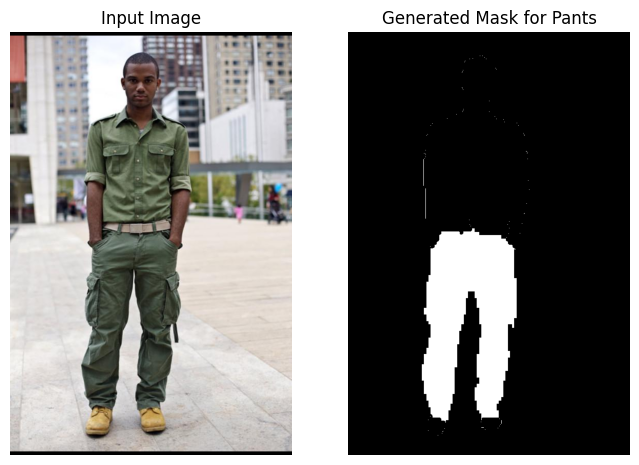

In [7]:
plt.figure(figsize=(8, 6))
plt.subplot(1, 2, 1)
plt.imshow(sourceImage)
plt.title('Input Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(mask, cmap='gray')
plt.title('Generated Mask for Pants')
plt.axis('off')

## Using Hugging Face Stable Diffusion 2 Inpainting Model

In [8]:
# ! pip install diffusers accelerate scipy safetensors

In [9]:
# ! pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cpu

In [10]:
from diffusers import StableDiffusionInpaintPipeline
import torch

In [11]:
# Checking GPU availability
print(torch.__version__)  # Should print the installed PyTorch version
print(torch.backends.mps.is_available())  # Should return True if MPS is available

2.6.0
True


In [12]:
pipe = StableDiffusionInpaintPipeline.from_pretrained(
    "stabilityai/stable-diffusion-2-inpainting",
    torch_dtype=torch.float16,
)
device = "mps" if torch.backends.mps.is_available() else "cpu"
pipe.to(device)

Loading pipeline components...: 100%|██████████| 6/6 [00:06<00:00,  1.01s/it]


StableDiffusionInpaintPipeline {
  "_class_name": "StableDiffusionInpaintPipeline",
  "_diffusers_version": "0.32.2",
  "_name_or_path": "stabilityai/stable-diffusion-2-inpainting",
  "feature_extractor": [
    "transformers",
    "CLIPImageProcessor"
  ],
  "image_encoder": [
    null,
    null
  ],
  "requires_safety_checker": false,
  "safety_checker": [
    null,
    null
  ],
  "scheduler": [
    "diffusers",
    "PNDMScheduler"
  ],
  "text_encoder": [
    "transformers",
    "CLIPTextModel"
  ],
  "tokenizer": [
    "transformers",
    "CLIPTokenizer"
  ],
  "unet": [
    "diffusers",
    "UNet2DConditionModel"
  ],
  "vae": [
    "diffusers",
    "AutoencoderKL"
  ]
}

In [13]:
def inPaint(imagePath, maskID, prompt):
    sourceImage, mask = generateInputs(imagePath, maskID)
    image = pipe(prompt=prompt, image=sourceImage, mask_image=mask).images[0]
    return image.resize((Winit, Hinit))

In [16]:
imagePath = 'ValDataset/png_images/IMAGES/img_0028.png'
prompt = "A photo of a person wearing green pants with military camouflage pattern"

100%|██████████| 50/50 [00:19<00:00,  2.55it/s]


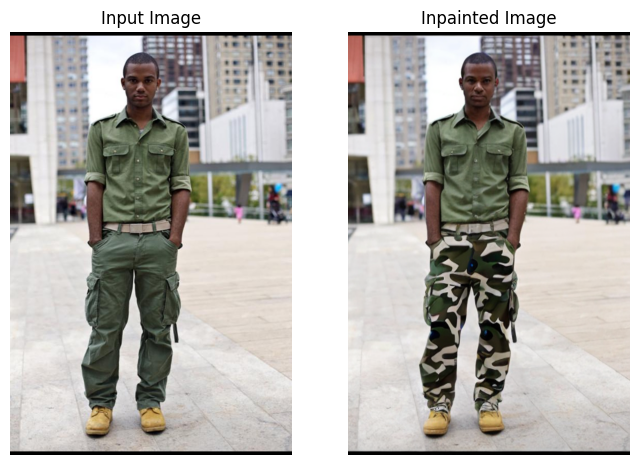

In [17]:
generatedImage = inPaint(imagePath, LABEL2ID['pants'], prompt)
plt.figure(figsize=(8, 6))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(cv2.imread(imagePath), cv2.COLOR_BGR2RGB))
plt.title('Input Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(generatedImage)
plt.title('Inpainted Image')
plt.axis('off')
plt.show()

In [23]:
sourceImage.save('TestImages/sourceImage.png')
generatedImage.save('TestImages/generatedImage.png')
mask.convert('L').save('TestImages/mask.png')